In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import torch.nn as nn

ModuleNotFoundError: No module named 'matplotlib'

In [250]:
def showTraj(V_mat, F_mat, ts, target, figaxs=None, show=True, alpha=0.5):
    if figaxs is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    else:
        fig, (ax1, ax2) = figaxs

    VS = V_mat.detach().cpu().numpy() if isinstance(V_mat, pt.Tensor) else np.stack([_.detach() for _ in V_mat])
    FS = F_mat.detach().cpu().numpy()

    # lw = 2 if alpha == 1 else 0.75+alpha
    lw = 2 if alpha == 1 else 1.5

    ax1.plot(VS[:,0], VS[:,1], lw=lw, zorder=6, color='dodgerblue', alpha=alpha)

    ax2.plot(ts[:-1], FS[:,0], 'deeppink', lw=lw, alpha=alpha, label='Acceleration Force' if show else None)
    ax2.plot(ts[:-1], FS[:,1], 'limegreen', lw=lw, alpha=alpha, label='Turning Force' if show else None)


    if show:
        ax1.scatter(VS[0,0], VS[0,1], marker='*', color='sandybrown', s=200, zorder=6, label='Start')
        ax1.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, label='Target')
        ax1.scatter(VS[-1,0], VS[-1,1], marker='o', color='dodgerblue', s=60, zorder=10, label='End')

        arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

        ax1.arrow(*VS[-1,0:2], *arrowDir(VS[-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)
        ax1.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=3, zorder=2)
        ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
        # ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)

        ax1.set_title('Trajectory')
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        ax1.axis('equal')
        ax1.grid()
        ax1.legend()

        ax2.legend()
        ax2.set_title('Forcing Terms')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Force')
        ax2.set_ylim([-0.85, 0.85])
        ax2.grid()
        plt.show()

    return fig, (ax1, ax2)

In [261]:
def V_step(V, F):
    phi = F[0]  # linear acceleration
    psi = F[1]  # angluar acceleration
    dt = F[2]   # timestep size
    dt2 = dt*dt/2

    x = V[0]    # x coordinate
    y = V[1]    # y coordinate
    a = V[2]    # angle
    s = V[3]    # speed
    w = V[4]    # angular speed
    t = V[5]    # time

    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w, t])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0])
    C3 = pt.stack([_0, _0, _1, _0, _0, _0])
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1])  # this is correct
    return A + phi*B + psi*C + dt*D

def loss_fun(Y, T, F, scale=None):
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T) * scale
    target_loss = pt.dot(diff, diff)                # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(F[:,0:2]**2)                  # loss by using too much force
    return target_loss, time_loss, l2_loss

def get_forcing(V, F):
    # limits based on current speed

    S = abs(V[...,3])
    turningRadius = 1

    psi_lim = pt.min(S / turningRadius, 0.8 * pt.ones_like(S))

    F_limited = pt.stack([
        pt.clamp(F[...,0], -0.8, 0.8),
        pt.clamp(F[...,1], -psi_lim, psi_lim),
        pt.clamp(F[...,2], 0.001, 0.25)
        ], dim=-1)

    return F_limited

# Compute a path while modifing V_mat and F_mat inplace
def compute_path_autograd(V0, F_request, target):
    V_list = [V0]
    F_true = []

    for i in range(F_request.shape[0]):
        F_true.append(get_forcing(V_list[i], F_request[i]))
        V_list.append(V_step(V_list[i], F_true[i]))
        # with pt.no_grad():
        #     F_request.data[i] = F_true[i]

    loss = loss_fun(V_list[-1], target, F_request)


    return V_list, loss

def to_tensor(V_mat):
    ten = pt.zeros((len(V_mat), V_mat[0].shape[0]))
    for i in range(len(V_mat)):
        ten[i] = V_mat[i].detach().cpu()
    return ten[:,0:5], ten[:,5]

Path has 32 steps with size 0.172s
Iteration 25, Target Dist: 2.1456034183502197, End Time: 4.727671146392822, L2: 0.368208110332489
Iteration 50, Target Dist: 0.48604902625083923, End Time: 4.183247089385986, L2: 0.3622405230998993
Iteration 75, Target Dist: 0.19672025740146637, End Time: 4.242238998413086, L2: 0.37756067514419556
Iteration 100, Target Dist: 0.053438905626535416, End Time: 4.334928035736084, L2: 0.39766013622283936
Iteration 125, Target Dist: 0.016170503571629524, End Time: 4.31317663192749, L2: 0.4242968261241913
Iteration 150, Target Dist: 0.011453140527009964, End Time: 4.282044410705566, L2: 0.45546555519104004
Iteration 175, Target Dist: 0.021371232345700264, End Time: 4.258174419403076, L2: 0.4778352677822113
Iteration 200, Target Dist: 0.01459133718162775, End Time: 4.249805450439453, L2: 0.5045517086982727
Iteration 225, Target Dist: 0.02525358647108078, End Time: 4.23280143737793, L2: 0.536297082901001
Iteration 250, Target Dist: 0.022543180733919144, End Tim

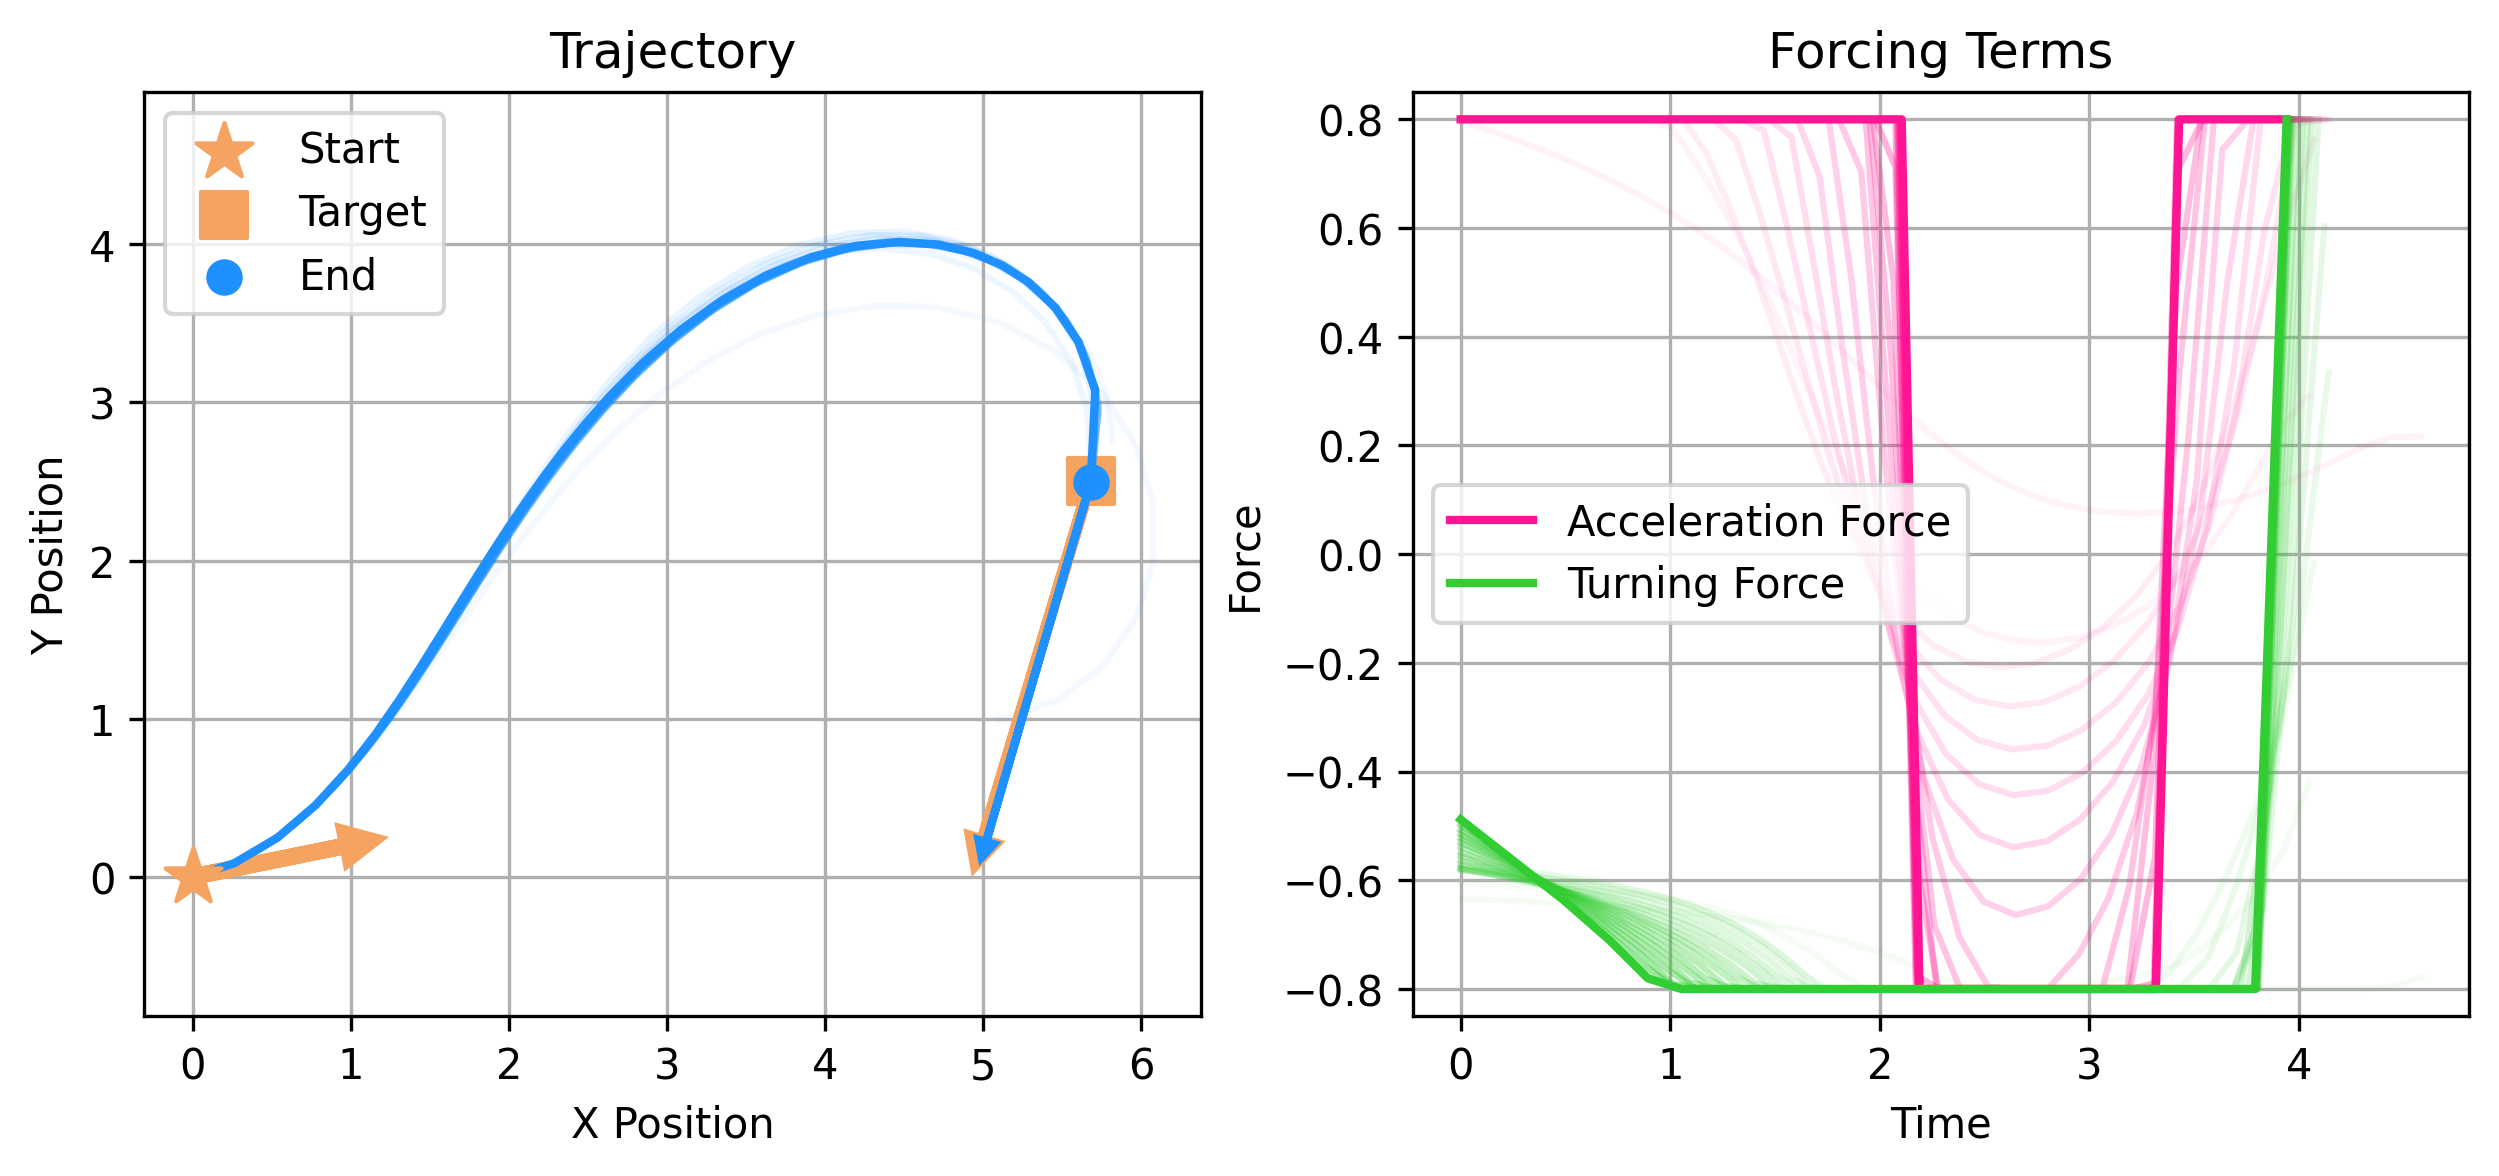

In [266]:
t0 = 0
t1 = 5.5       # designed for 5.5
dt_max = 0.25
n_steps = 2**np.ceil(np.log2((t1 - t0)/ dt_max)).astype(int)
print(f'Path has {n_steps} steps with size {(t1-t0)/n_steps:0.3g}s')

v0 = pt.tensor([0, 0, 0.2, 1, 1, t0], requires_grad=True)
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

F_mat = nn.Parameter(0 * pt.randn((n_steps, 3)))
V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

optim = pt.optim.AdamW([F_mat], lr=6e-2, weight_decay=0)


pt.autograd.set_detect_anomaly(False)

figaxs = None
nsteps = 500
mode = 'Target'

for i in range(nsteps):
    optim.zero_grad()
    V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)


    dist = target_loss ** 0.5

    if mode == 'Target' and dist < 0.02:
        mode = 'Time'
    if mode == 'Time' and dist > 0.05:
        mode = 'Target'

    l2_coef = -1e0
    # time_coef = 1e-6 / target_loss if mode == 'Time' else 0
    time_coef = 1e-8


    loss = target_loss + time_coef*time_loss + l2_coef*l2_loss
    loss.backward()
    optim.step()

    with pt.no_grad():
        F_mat.copy_(get_forcing(pt.stack(V_mat[:-1]), F_mat))

    if i % 25 == 24:
        print(f"Iteration {i+1}, Target Dist: {target_loss ** 0.5}, End Time: {time_loss}, L2: {l2_loss}")
        if i < nsteps-1:
            traj, ts = to_tensor(V_mat)
            figaxs = showTraj(traj, F_mat, ts, target, figaxs=figaxs, show=False, alpha=0.5*max(0.1, i/nsteps))

traj, ts = to_tensor(V_mat)
_ = showTraj(traj, F_mat, ts, target, figaxs=figaxs, show=True, alpha=1.0)

In [267]:
print(traj[-1,:])
print(V_mat[-1])
pt.set_printoptions(sci_mode=False)

# print(f'{F_mat:.3g}')
print(F_mat)
print(ts)

tensor([ 5.68241,  2.49682, -1.85398,  2.37091, -1.76187])
tensor([ 5.68241,  2.49682, -1.85398,  2.37091, -1.76187,  4.19056],
       grad_fn=<AddBackward0>)
Parameter containing:
tensor([[ 0.80000, -0.48816,  0.25000],
        [ 0.80000, -0.56349,  0.24520],
        [ 0.80000, -0.63771,  0.21353],
        [ 0.80000, -0.70958,  0.18544],
        [ 0.80000, -0.78048,  0.16056],
        [ 0.80000, -0.80000,  0.14002],
        [ 0.80000, -0.80000,  0.12350],
        [ 0.80000, -0.80000,  0.11009],
        [ 0.80000, -0.80000,  0.09916],
        [ 0.80000, -0.80000,  0.09114],
        [ 0.80000, -0.80000,  0.08541],
        [ 0.80000, -0.80000,  0.08171],
        [ 0.80000, -0.80000,  0.07952],
        [ 0.80000, -0.80000,  0.07899],
        [ 0.80000, -0.80000,  0.07968],
        [ 0.80000, -0.80000,  0.08028],
        [ 0.80000, -0.80000,  0.08516],
        [-0.80000, -0.80000,  0.10896],
        [-0.80000, -0.80000,  0.11942],
        [-0.80000, -0.80000,  0.12760],
        [-0.80000, 